(C) Gerold Baier, University College London, 2024

# Dynamics of 2 Coupled Oscillators with Homoclinic/SNIC 


Model: 2 oscillators (preset using h_ex) with symmetric Excitatory Coupling between Ex_1 and Ex_2.

Task: Find conditions that allow propagation of excitation from oscillator 1 to oscillator 2. 

Ansatz: Scan the response in Initial Conditions space for both oscillators with 'coupling_strength_EE' starting from zero. The case 0 is already known. 

Starting point: the bifurcation diagram as a function of h_ex for changing values of 'coupling_strength_EE'. 

Result:

1. If coupling strength 'coupling_strength_EE' is increased from zero, the location of the HC bifurcation changes.
2. Thus for any initial condition scan (searching for excitability), the h_ex Parameter needs adjustment to find abnormal responses.
3. With this adjustment, conditions for spreading of erxcitation to the neighbour oscillator can be found because the excitation in the neighbour increases with increasing coupling strength.

Conclusion: Increase in coupling can lead to sufficiently strong perturbation of a coupled oscillator to induce excitation. By implication this is a starting point for spreading of abnormal acitivty. It is essential to show responses with increasing coupling strength 'coupling_strength_EE' as a function of the adjustment of the h_ex Parameter. It would be good to have a measure of "excitability" do the adjustment automatically. This constitutes a "functional" measure of excitability. 



## Import

In [1]:
from scipy.integrate import odeint

from scipy.signal import find_peaks

from numpy import zeros, ones, tanh, mod, linspace
from numpy import fill_diagonal, ndarray, amax, amin
from numpy import asarray, array, around, arange, corrcoef, flip, var, append
from numpy.random import default_rng

from matplotlib.pyplot import subplots

from itertools import product


## Model and Functions

In [2]:
def sigmoid(u):
    return tanh(u)

def N_oscillators(y, t, N, h_ex_rand, h_in_rand, coupling_matrix_EE, pars):

    tau_ex, tau_in, c1, c2, c3, c4 = pars

    if  N == 1:

        h_ex = h_ex_rand
        h_in = h_in_rand

        dydt = (
            (h_ex - y[0] + c1*sigmoid(y[0]) - c2*sigmoid(y[1]))*tau_ex,
            (h_in - y[1] + c3*sigmoid(y[0]) - c4*sigmoid(y[1]))*tau_in
       )
        
    else:
        
        coup_matrix_EE_scaled = coupling_matrix_EE / (N-1)
        
        # Separate Variables
        y_ex = y[:-1:2]
        y_in = y[1::2]

        dy_ex, dy_in = zeros(N), zeros(N)
        dydt = zeros(2*N)

        for osc in arange(N):
            
            coup_EE = sum(coup_matrix_EE_scaled[:, osc] * y_ex)
                
            dy_ex[osc] = (h_ex_rand[osc] - y_ex[osc] + c1*sigmoid(y_ex[osc]) - c2*sigmoid(y_in[osc]) + coup_EE)*tau_ex
            dy_in[osc] = (h_in_rand[osc] - y_in[osc] + c3*sigmoid(y_ex[osc]) - c4*sigmoid(y_in[osc])          )*tau_in
                                                       

    # Combine Variables

        dydt[:-1:2] = dy_ex
        dydt[1: :2] = dy_in

    return dydt


def N_osc_pert(y, t, N, coupling_matrix_E, coupling_matrix_I, pert_osc,
               sr, time_stop_s, h_ex_rand, h_in_rand, h_ex_p, h_in_p, pars):

    tau_ex, tau_in, c1_ex, c2_ex, c3_in, c4_in = pars


    h_ex_index = int(t*sr)
    
    if h_ex_index >= time_stop_s*sr:

        dydt = zeros(2*N)
        
        return dydt
    
    if  N == 1:

        dydt = (
                (h_ex_p[h_ex_index] - y[0] + c1_ex*sigmoid(y[0]) - 
                 c2_ex*sigmoid(y[1]))*tau_ex,
                (h_in_p[h_ex_index] - y[1] + c3_in*y[0]          - 
                 c4_in*sigmoid(y[1]))*tau_in
        )

    else:
        
        coup_matrix_E_scaled = coupling_matrix_E / (N-1)
        coup_matrix_I_scaled = coupling_matrix_I / (N-1)
        
        # Separate Variables
        y_ex = y[:-1:2]
        y_in = y[1::2]

        dy_ex, dy_in = zeros(N), zeros(N)
        dydt = zeros(2*N)
    
        
        for osc in arange(N):
         
            coup_E = sum(coup_matrix_E_scaled[:, osc] * y_ex)
            coup_I = sum(coup_matrix_I_scaled[:, osc] * y_in)
                            
            if osc == pert_osc:

                dy_ex[osc] = (h_ex_p[h_ex_index] - y_ex[osc] + c1_ex*sigmoid(y_ex[osc]) - 
                              c2_ex*sigmoid(y_in[osc]) + coup_E)*tau_ex 
                dy_in[osc] = (h_in_p[h_ex_index] - y_in[osc] + c3_in*y_ex[osc]          - 
                              c4_in*sigmoid(y_in[osc]) + coup_I)*tau_in

            else:

                dy_ex[osc] = (h_ex_rand[osc] - y_ex[osc] + c1_ex*sigmoid(y_ex[osc]) - 
                              c2_ex*sigmoid(y_in[osc]) + coup_E)*tau_ex 
                dy_in[osc] = (h_in_rand[osc] - y_in[osc] + c3_in*y_ex[osc]          - 
                              c4_in*sigmoid(y_in[osc]) + coup_I)*tau_in


    # Combine Variables

    dydt[:-1:2] = dy_ex
    dydt[1: :2] = dy_in

    return dydt


In [3]:
def plot_series(time, data, time_begin, time_end, sr):
    
    N = data.shape[1]//2
    
    name_vars = ('Ex_', 'In_')

    no_vars = len(name_vars)

    if N == 1:

        fig, ax = subplots(ncols=len(name_vars), figsize=(8, 4))

        for ind in arange(no_vars):
      
            ax[ind].plot(time[time_begin*sr:time_end*sr], data[time_begin*sr:time_end*sr, ind], linewidth=2, c='b')
            # ax[ind].set_xticks(linspace(time_begin*sr, (time_end-time_begin)*sr, 5));
            ax[ind].set_xticks(linspace(time_begin, time_end, 5));
            ax[ind].set_xticklabels(linspace(time_begin, time_end, 5));

            # ax[ind].set_xticklabels([]);
            ax[ind].set_xlabel('Time', fontsize=14);
            ax[ind].set_ylabel(name_vars[ind], fontsize=14)
            y_min, y_max = ax[ind].get_ylim()
            ax[ind].set_yticks(linspace(y_min, y_max, 3));
            ax[ind].set_yticklabels(around(linspace(y_min, y_max, 3),1), fontsize=14);

    else:

        y_max1 = amax(data[:, arange(0, 2*N, 2)])

        if y_max1 > 0:

            y_max1_ax = 1.1*y_max1

        else:

            y_max1_ax = 0.9*y_max1


        y_min1 = amin(data[:, arange(0, 2*N, 2)])

        if y_min1 > 0:

            y_min1_ax = 0.9*y_min1

        else:

            y_min1_ax = 1.1*y_min1


        y_max2 = amax(data[:, arange(1, 2*N+1, 2)])

        if y_max2 > 0:

            y_max2_ax = 1.1*y_max2

        else:

            y_max2_ax = 0.9*y_max2   


        y_min2 = amin(data[:, arange(1, 2*N+1, 2)])

        if y_min2 > 0:

            y_min2_ax = 0.9*y_min2

        else:

            y_min2_ax = 1.1*y_min2


        fig, ax = subplots(ncols=len(name_vars), nrows=N, figsize=(10, 6))

        for osc in arange(N):
            for ind in arange(2):

                if ind == 0:
                    ax[osc, ind].plot(time[time_begin*sr:time_end*sr], data[time_begin*sr:time_end*sr, 2*osc+ind], linewidth=1, c='b')
                    ax[osc, ind].set_xticklabels([]);
                    ax[osc, ind].set_ylim(y_min1_ax, y_max1_ax)   
                    ax[osc, ind].set_yticks(linspace(y_min1_ax, y_max1_ax, 3));
                    ax[osc, ind].set_yticklabels(around(linspace(y_min1_ax, y_max1_ax, 3),1), fontsize=14);

                elif ind == 1:
                    ax[osc, ind].plot(time[time_begin*sr:time_end*sr], data[time_begin*sr:time_end*sr, 2*osc+ind], linewidth=1, c='r')
                    ax[osc, ind].set_xticklabels([]);
                    ax[osc, ind].set_ylim(y_min2_ax, y_max2_ax)
                    ax[osc, ind].set_yticks(linspace(y_min2_ax, y_max2_ax, 3));
                    ax[osc, ind].set_yticklabels(around(linspace(y_min2_ax, y_max2_ax, 3),1), fontsize=14);

                if osc == N-1:

                    ax[N-1, ind].set_xlabel('Time', fontsize=14);
                    # print(time[time_begin*sr:time_end*sr].size)
                    # print((time_end-time_begin)*sr)
                    ax[N-1, ind].set_xticks(linspace(time_begin, time_end, 5));
                    ax[N-1, ind].set_xticklabels(linspace(time_begin, time_end, 5));

                label_text = name_vars[ind] + str(osc+1)

                ax[osc, ind].set_ylabel(label_text, fontsize=14)

    fig.tight_layout()
    
    return fig, ax


def plot_bifdiagram(results_min_f, results_max_f, results_min_b, results_max_b, 
                    par_set):
    
    '''Plot of Bifurcation Diagram'''


    N = len(results_min_f)
    
    osc = 0

    fig, ax = subplots(figsize=(6, 3))

    # Forward
    for xe, ye in zip(par_set, results_min_f[osc]):

        if not isinstance(ye, ndarray):
                
            ax.scatter(xe, ye, c='k', s=8)   
                
        else:

            # print(len(ye))
            ax.scatter([xe] * len(ye), ye, c='m', s=8)

    for xe, ye in zip(par_set, results_max_f[osc]):

        if not isinstance(ye, ndarray):
                
            ax.scatter(xe, ye, c='k', s=8)   
                
        else:

            # print(len(xe), len(ye))
            ax.scatter([xe] * len(ye), ye, c='m', s=8)         


    # Backward
    for xe, ye in zip(flip(par_set), results_min_b[osc]):

        if not isinstance(ye, ndarray):
                
            ax.scatter(xe, ye, c='k', s=8)   
                
        else:
            
            ax.scatter([xe] * len(ye), ye, c='b', s=8)

    for xe, ye in zip(flip(par_set), results_max_b[osc]):

        if not isinstance(ye, ndarray):
                
            ax.scatter(xe, ye, c='k', s=8)   
                
        else:
            
            ax.scatter([xe] * len(ye), ye, c='b', s=8)


    ax.set_xticks(linspace(par_min, par_max, 6))
    ax.set_xticklabels([])

    y_min, y_max = ax.get_ylim()

    ax.set_yticks(linspace(y_min, y_max, 3));
    ax.set_yticklabels(around(linspace(y_min, y_max, 3),1), fontsize=16);

    label_text = 'EX_1'
    ax.set_ylabel(label_text, fontsize=14)

    ax.set_xticks(linspace(par_min, par_max, 6));
    ax.set_xticklabels(around(linspace(par_min, par_max, 6), 3), fontsize=16);

    fig.tight_layout()
    
    return fig, ax


def plot_bifdiagram_T(results_T1_min_f, results_T2_min_f, 
                          results_T1_min_b, results_T2_min_b, 
                          results_T1_max_f, results_T2_max_f, 
                          results_T1_max_b, results_T2_max_b, 
                          par_set, IC_state):
    
    '''Plot of Bifurcation Diagram'''


    N = len(results_T1_min_f)
    
    osc = 0

    fig, ax = subplots(figsize=(6, 3), dpi=300)

    # Forward
    for xe, ye in zip(par_set, results_T1_min_f[osc]):

        if not isinstance(ye, ndarray) and xe > 0.04:
                
            ax.scatter(xe, ye, c='r', s=8)   
                
        else:

            pass
            # ax.scatter([xe] * len(ye), ye, c='r', s=8)

    for xe, ye in zip(par_set, results_T1_max_f[osc]):

        if not isinstance(ye, ndarray) and xe > 0.04:
                
            ax.scatter(xe, ye, c='r', s=8)   
                
        else:

            pass
            # ax.scatter([xe] * len(ye), ye, c='r', s=8)
            


    for xe, ye in zip(par_set, results_T2_min_f[osc]):

        if not isinstance(ye, ndarray) and xe > 0.04:
                
            ax.scatter(xe, ye, c='b', s=8)   
                
        else:

            pass
            # ax.scatter([xe] * len(ye), ye, c='b', s=8)

    for xe, ye in zip(par_set, results_T2_max_f[osc]):

        if not isinstance(ye, ndarray) and xe > 0.04:
                
            ax.scatter(xe, ye, c='b', s=8)   
                
        else:

            pass
            # ax.scatter([xe] * len(ye), ye, c='b', s=8)
         


    # Backward
    for xe, ye in zip(par_set, results_T1_min_b[osc]):

        if not isinstance(ye, ndarray):
                
            ax.scatter(xe, ye, c='k', s=8)   
                
        else:
            
            ax.scatter([xe] * len(ye), ye, c='k', s=8)

    for xe, ye in zip(par_set, results_T1_max_b[osc]):

        if not isinstance(ye, ndarray):
                
            ax.scatter(xe, ye, c='k', s=8)   
                
        else:
            
            ax.scatter([xe] * len(ye), ye, c='k', s=8)
            


    for xe, ye in zip(par_set, results_T2_min_b[osc]):

        if not isinstance(ye, ndarray):
                
            ax.scatter(xe, ye, c='k', s=8)   
                
        else:
            
            ax.scatter([xe] * len(ye), ye, c='k', s=8)

    for xe, ye in zip(par_set, results_T2_max_b[osc]):

        if not isinstance(ye, ndarray):
                
            ax.scatter(xe, ye, c='k', s=8)   
                
        else:
            
            ax.scatter([xe] * len(ye), ye, c='k', s=8)
         


    # for xe, ye in zip(flip(par_set), results_T1_b[osc]):

    #     if not isinstance(ye, ndarray):
                
    #         ax.scatter(xe, ye, c='k', s=8)   
                
    #     else:
            
    #         ax.scatter([xe] * len(ye), ye, c='k', s=8)


    # for xe, ye in zip(flip(par_set), results_T2_b[osc]):

    #     if not isinstance(ye, ndarray):
            
    #         ax.scatter(xe, ye, c='k', s=8)

    #     else:
            
    #         ax.scatter([xe] * len(ye), ye, c='k', s=8, marker='P')


    ax.set_xticks(linspace(par_min, par_max, 6))
    ax.set_xticklabels([])

    y_min, y_max = ax.get_ylim()

    ax.set_yticks(linspace(y_min, y_max, 3));
    ax.set_yticklabels(around(linspace(y_min, y_max, 3),1), fontsize=16);

    label_text = 'EX_1'
    ax.set_ylabel(label_text, fontsize=14)

    ax.set_xticks(linspace(par_min, par_max, 6));
    ax.set_xticklabels(around(linspace(par_min, par_max, 6), 3), fontsize=16);
                       
    # if par_set[-1] < par_set[0]:
                           
    #     chars = 'Right'
                           
    # else:
                  
    #     chars = 'Left'

    # title_chars = 'Starts from: ' + chars
    # fig.suptitle(title_chars, fontsize=16)

    fig.tight_layout()
    
    return fig, ax

def plot_pert_scan(results_pert_matrix, N, pert_osc, vmin, vmax):

    no_ticklabels = 6

    fig, ax = subplots(nrows=N, figsize=(6, 6))


    if N == 1:

        im = ax.imshow(results_pert_matrix[:,:,0].T, cmap='bwr', vmin=vmin, vmax=vmax)

        fig.colorbar(im, ax=ax, shrink=0.6);

        label_chars = 'Perturbed Oscillator'

        ax.set_title(label_chars, fontsize=16)
        ax.set_ylabel('Pulse Amplitude', fontsize=16)
        ax.set_xticks(linspace(0, resolution-1, no_ticklabels))
        ax.set_xticklabels(around(linspace(pulse_width_min, pulse_width_max, no_ticklabels), 2))
        ax.set_yticks(linspace(0, resolution-1, no_ticklabels))
        ax.set_yticklabels(around(linspace(pulse_ampli_min, pulse_ampli_max, no_ticklabels), 2))
        ax.set_xlabel('Pulse Width', fontsize=16)

    else:

        for col in arange(N):

            im = ax[col].imshow(results_pert_matrix[:,:, col].T, cmap='bwr', vmin=vmin, vmax=vmax)

            fig.colorbar(im, ax=ax[col], shrink=0.6);

            label_chars = 'Osc ' + str(col+1)

            if col == pert_osc:

                label_chars += ' (perturbed)'

            ax[col].set_title(label_chars, fontsize=16)
            ax[col].set_ylabel('Pulse Amplitude', fontsize=16)
            ax[col].set_xticks(linspace(0, resolution-1, no_ticklabels))
            ax[col].set_xticklabels(around(linspace(pulse_width_min, pulse_width_max, no_ticklabels), 2))
            ax[col].set_yticks(linspace(0, resolution-1, no_ticklabels))
            ax[col].set_yticklabels(around(linspace(pulse_ampli_min, pulse_ampli_max, no_ticklabels), 2))

            if col == N-1:
                ax[col].set_xlabel('Pulse Width', fontsize=16)
                
    fig.tight_layout()

    return fig, ax


def plot_pert_scan_ex_in(results_pert_matrix, N, pert_osc, vmin, vmax):

    no_ticklabels = 6

    fig, ax = subplots(nrows=N, figsize=(6, 6))


    if N == 1:

        im = ax.imshow(results_pert_matrix[:,:,0].T, cmap='bwr', vmin=vmin, vmax=vmax)

        fig.colorbar(im, ax=ax, shrink=0.6);

        label_chars = 'Perturbed Oscillator'

        ax.set_title(label_chars, fontsize=16)
        ax.set_ylabel('Inh. Amplitude', fontsize=12)
        ax.set_xticks(linspace(0, resolution-1, no_ticklabels))
        ax.set_xticklabels(around(linspace(pulse_ex_min, pulse_ex_max, no_ticklabels), 2))
        ax.set_yticks(linspace(0, resolution-1, no_ticklabels))
        ax.set_yticklabels(around(linspace(pulse_in_min, pulse_in_max, no_ticklabels), 2))
        ax.set_xlabel('Exc. Amplitude', fontsize=12)

    else:

        for col in arange(N):

            im = ax[col].imshow(results_pert_matrix[:,:, col].T, cmap='bwr', vmin=vmin, vmax=vmax)

            fig.colorbar(im, ax=ax[col], shrink=0.6);

            label_chars = 'Osc ' + str(col+1)

            if col == pert_osc:

                label_chars += ' (perturbed)'

            ax[col].set_title(label_chars, fontsize=16)
            ax[col].set_ylabel('Inh. Amplitude', fontsize=12)
            ax[col].set_xticks(linspace(0, resolution-1, no_ticklabels))
            ax[col].set_xticklabels(around(linspace(pulse_ex_min, pulse_ex_max, no_ticklabels), 2))
            ax[col].set_yticks(linspace(0, resolution-1, no_ticklabels))
            ax[col].set_yticklabels(around(linspace(pulse_in_min, pulse_in_max, no_ticklabels), 2))

            if col == N-1:
                ax[col].set_xlabel('Exc. Amplitude', fontsize=12)
                
    fig.tight_layout()

    return fig, ax


## Parameters

In [33]:
# Number of oscillators
N = 2

# Model Parameters
h_ex_0 = -1.95
h_in_0 = -4

eps  = 0.00001

SEED = 123

rng = default_rng(SEED)

if N == 1:

    h_ex_rand = h_ex_0
    h_in_rand = h_in_0

elif N > 1:

    h_ex_rand = h_ex_0 + eps*rng.normal(0,1,size=N)
    h_in_rand = h_in_0 + eps*rng.normal(0,1,size=N)

# Homoclinic / SNIC parameters
pars = (1, 1, 4, 4, 10, 0) # SNIC
pars = (1, 2, 4, 4, 10, 0) # Homoclinic / SN

if N == 1:

    coupling_matrix_EE_graded = 0

elif N == 2:

    coupling_matrix_EE_graded = ones(shape=(N, N))

    fill_diagonal(coupling_matrix_EE_graded, 0)


coupling_strength_EE = 0.5

coupling_matrix_EE   = coupling_strength_EE * coupling_matrix_EE_graded

# Time array
time_stop = 50
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)


In [34]:
h_ex_rand

array([-1.95000989, -1.95000368])

## Time Series


In [35]:
# Pick Initial conditions

SEED_2 = 12345

rng = default_rng(SEED_2)

y_ini = rng.uniform(size=2*N)*5
# y_ini = y[-1, :]
# y_ini = [ex1_val, in1_val, y_ss[2], y_ss[3]]

# Simulation
y = odeint(func=N_oscillators, y0=y_ini, t=time, 
          args=(N, h_ex_rand, h_in_rand, coupling_matrix_EE, pars), 
          hmax=0.1)

y_ss = y[-1, :]

# Show final values of all variables
print('End of run:', list(around(y_ss, 3)))
print('')


End of run: [-3.893, -13.992, -3.893, -13.992]



'Figs/N=2/Series_Homoclinic_coup_EE=0.5  h_ex=-1.95.png'

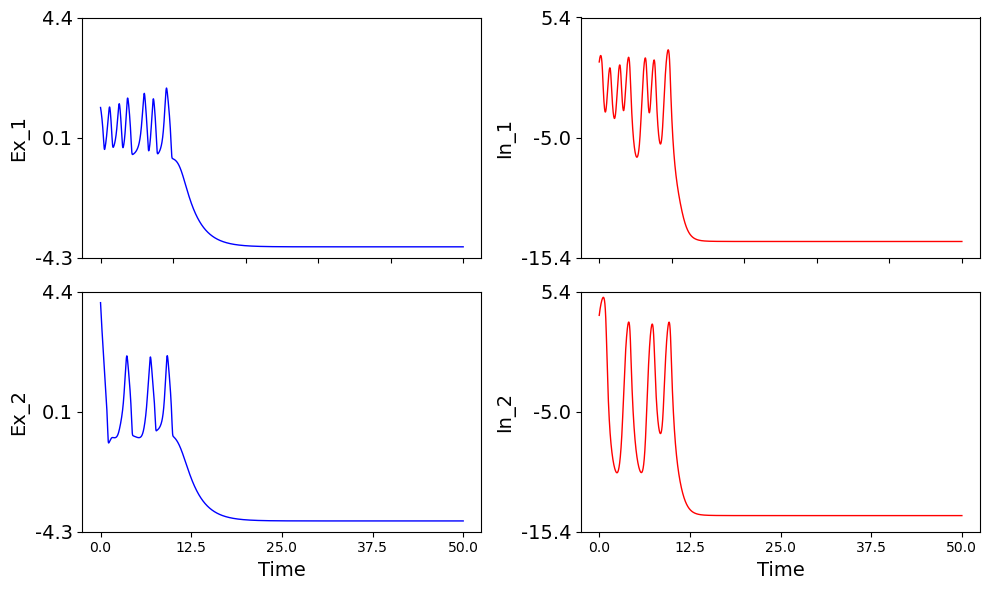

In [36]:
time_begin, time_end = 0, time_stop

fig, ax = plot_series(time, y, time_begin, time_end, sr)

if pars[1] == 1:
    
    title_chars = 'Figs/N=2/Series_SNIC_coup_EE=' + str(coupling_strength_EE) + ' h_ex.png'
    
elif pars[1] == 2:

    title_chars = 'Figs/N=2/Series_Homoclinic_coup_EE=' + str(coupling_strength_EE) + '  h_ex=' + str(h_ex_0) + '.png'
    

# fig.savefig(title_chars, format='png')
title_chars


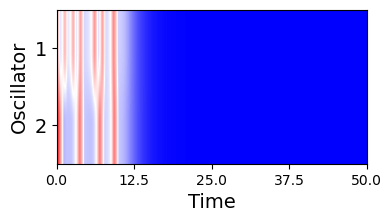

In [37]:
fig, ax = subplots(figsize=(4, 2))

ax.imshow(y[:, ::2].T, aspect='auto', cmap='bwr');

ax.set_xticks(linspace(time_begin, time_end*sr, 5));
ax.set_xticklabels(linspace(time_begin, time_end, 5));

ax.set_yticks((0, 1));
ax.set_yticklabels((1, 2), fontsize=14);

ax.set_xlabel('Time', fontsize=14);
ax.set_ylabel('Oscillator', fontsize=14);

## Bifurcation Diagram

In [16]:
y_ini = y[-1, :]

par_choice = 'h_ex' # 'ex' or 'h_ex'

# Bifurcation parameter set
steps = 20
par_min, par_max = -2.2, -1.0
par_set = linspace(par_min, par_max, steps)

results_min_f      = dict()
results_min_inds_f = dict()
results_max_f      = dict()
results_max_inds_f = dict()

rows = time.size

# Simulation "forward"
for par in par_set:
    
    if par_choice == "ex":
    
        coupling_matrix_EE = par * coupling_matrix_EE_graded


        y_f = odeint(func=N_oscillators, y0=y_ini, t=time, 
                 args=(N, h_ex_rand, h_in_rand, coupling_matrix_EE, pars), hmax=0.1)

    elif par_choice == "h_ex":

        rng = default_rng(SEED)
    
        h_ex_rand = par + eps*rng.normal(0,1,size=N)

    
        y_f = odeint(func=N_oscillators, y0=y_ini, t=time, 
                 args=(N, h_ex_rand, h_in_rand, coupling_matrix_EE, pars), hmax=0.1)


    for num, series in enumerate(y_f[rows//2:,:-1:2].T):
                
        if var(series) < 0.0001:
    
            if num not in results_min_f:
                
                results_min_f[num]      = [series[-1]]
                results_min_inds_f[num] = [0]    
               
            else:
                results_min_f[num].append(series[-1])
                results_min_inds_f[num].append(0)    

            if num not in results_max_f:
                
                results_max_f[num]      = [series[-1]]
                results_max_inds_f[num] = [0]    
               
            else:
                results_max_f[num].append(series[-1])
                results_max_inds_f[num].append(0)    

        else:
            
            y_f_max_inds = find_peaks(series, distance=20)
            y_f_maxs     = series[y_f_max_inds[0]]
    
            y_f_min_inds = find_peaks(-series, distance=20)
            y_f_mins     = series[y_f_min_inds[0]]
    
            if num not in results_min_f:
    
                results_min_f[num]      = [y_f_mins]
                results_min_inds_f[num] = [y_f_min_inds]
                
                results_max_f[num]      = [y_f_maxs]
                results_max_inds_f[num] = [y_f_max_inds]
    
            else:
    
                results_min_f[num].append(y_f_mins)
                results_min_inds_f[num].append(y_f_min_inds)
                
                results_max_f[num].append(y_f_maxs)
                results_max_inds_f[num].append(y_f_max_inds)


    if par != par_set[-1]:
        
        y_ini = y_f[-1, :]


results_min_b      = dict()
results_min_inds_b = dict()
results_max_b      = dict()
results_max_inds_b = dict()


# Simulation "backward"
for par in flip(par_set):

    if par_choice == "ex":

        coupling_matrix_EE_par = par * coupling_matrix_EE_graded

        y_bif = odeint(func=N_oscillators, y0=y_ini, t=time, 
                 args=(N, h_ex_rand, h_in_rand, coupling_matrix_EE, pars), hmax=0.1)

    elif par_choice == "h_ex":

        rng = default_rng(SEED)

        h_ex_rand = par + eps*rng.normal(0,1,size=N)

        y_bif = odeint(func=N_oscillators, y0=y_ini, t=time, 
                 args=(N, h_ex_rand, h_in_rand, coupling_matrix_EE, pars), hmax=0.1)



    for num, series in enumerate(y_bif[rows//2:,:-1:2].T):

        if var(series) < 0.00005:

            if num not in results_min_b:
                
                results_min_b[num]      = [series[-1]]
                results_min_inds_b[num] = [0]    
               
            else:
                results_min_b[num].append(series[-1])
                results_min_inds_b[num].append(0)    

            if num not in results_max_b:
                
                results_max_b[num]      = [series[-1]]
                results_max_inds_b[num] = [0]    
               
            else:
                results_max_b[num].append(series[-1])
                results_max_inds_b[num].append(0)    

        else:

            y_b_max_inds = find_peaks(series, distance=100)
            y_b_maxs     = series[y_b_max_inds[0]]

            y_b_min_inds = find_peaks(-series, distance=100)
            y_b_mins     = series[y_b_min_inds[0]]

            if num not in results_min_b:

                results_min_b[num]      = [y_b_mins]
                results_min_inds_b[num] = [y_b_min_inds]
                
                results_max_b[num]      = [y_b_maxs]
                results_max_inds_b[num] = [y_b_max_inds]

            else:

                results_min_b[num].append(y_b_mins)
                results_min_inds_b[num].append(y_b_min_inds)
                
                results_max_b[num].append(y_b_maxs)
                results_max_inds_b[num].append(y_b_max_inds)


    y_ini = y_bif[-1, :]

print('')
print('Scan complete!', list(around(y_bif [-1,:], 2)))
print('')



Scan complete! [-4.4, -14.0, -4.4, -14.0]



'Figs/N=2/Bifs_Homoclinic_coup_EE=0.5  h_ex.png'

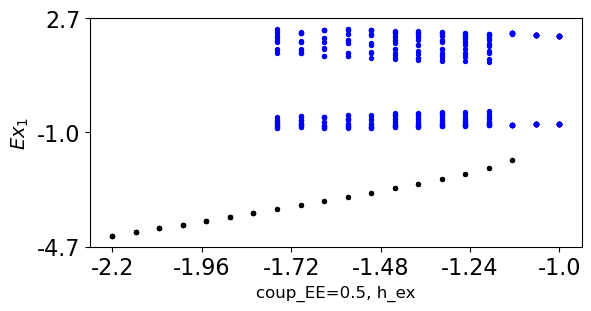

In [17]:
fig, ax = plot_bifdiagram(results_min_f, results_max_f, 
                          results_min_b, results_max_b, par_set)

if par_choice == "ex":

    ax.set_xlabel('coup_EE, h_ex=' + str(h_ex_0), fontsize=12)
    
elif par_choice == "h_ex":

    ax.set_xlabel('coup_EE='  + str(coupling_strength_EE) + ', h_ex', fontsize=12)
        
    ax.set_ylabel('$Ex_{1}$')

if pars[1] == 1:
    
    title_chars = 'Figs/N=2/Bifs_SNIC_coup_EE=' + str(coupling_strength_EE) + ' h_ex.png'
    
elif pars[1] == 2:

    title_chars = 'Figs/N=2/Bifs_Homoclinic_coup_EE=' + str(coupling_strength_EE) + '  h_ex.png'
    

# fig.savefig(title_chars, format='png')
title_chars


## Check IC and Coupling

In [38]:
print('Steady State:', around(y_ss, 2))
print('')
print('Excitatory Coupling:')
print(coupling_matrix_EE)


Steady State: [ -3.89 -13.99  -3.89 -13.99]

Excitatory Coupling:
[[0.  0.5]
 [0.5 0. ]]


## Scan of Initial Conditions

IC of oscillator 1, response in oscillator 2

Complete



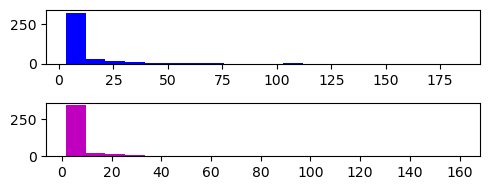

In [39]:
resolution = 20

ex1_min, ex1_max = -1, 1.5
in1_min, in1_max = 2, -7

ex1_0 = linspace(ex1_min, ex1_max, resolution)
in1_0 = linspace(in1_min, in1_max, resolution)

results = list()

for osc1_ini in product(ex1_0, in1_0):

# Simulation
    y_IC = odeint(func=N_oscillators, 
             y0=[osc1_ini[0], osc1_ini[1], y_ss[2], y_ss[3]], t=time, 
             args=(N, h_ex_rand, h_in_rand, coupling_matrix_EE, pars), 
             hmax=0.1)

    
    results.append((sum(y_IC[:, 0] - y_ss[0])/sr, 
                    sum(y_IC[:, 2] - y_ss[2])/sr
                   ))

results_Ex1_matrix = asarray(results)[:, 0].reshape(resolution, resolution)
results_Ex2_matrix = asarray(results)[:, 1].reshape(resolution, resolution)

print('Complete')
print('')

fig, ax = subplots(nrows=2, figsize=(5, 2))

ax[0].hist(results_Ex1_matrix.ravel(), bins=20, color='b');
ax[1].hist(results_Ex2_matrix.ravel(), bins=20, color='m');

fig.tight_layout()


The histograms show the lengths of the responses in both oscillators. Most are short which means quick return to fixed point. Long responses in oscillator 1 show that for some initial conditions there is excitability. Long responses in oscillator 2 show that for some initial conditions there is spreading of excitation from oscillator 1 to oscillator 2. 

Figs/N=1/Fig_2Ba_Basin_Homoclinic.png


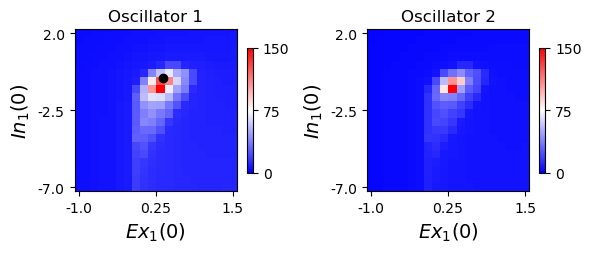

In [40]:
ex1_val, in1_val = 0.3, -0.5

pos_ex = resolution*(ex1_val - ex1_min)/((ex1_max - ex1_min))
pos_in = resolution*(in1_val - in1_min)/((in1_max - in1_min))

fig, ax = subplots(ncols=2, figsize=(6, 3))

vmin, vmax = 0, 150

im1 = ax[0].imshow(results_Ex1_matrix.T, cmap='bwr', vmin=vmin, vmax=vmax)
im2 = ax[1].imshow(results_Ex2_matrix.T, cmap='bwr', vmin=vmin, vmax=vmax)

ax[0].set_title('Oscillator 1')
ax[0].set_xlabel('$Ex_1(0)$', fontsize=14)
ax[0].set_ylabel('$In_1(0)$', fontsize=14)
ax[0].set_xticks(linspace(0, resolution-1, 3))
ax[0].set_xticklabels(linspace(ex1_min, ex1_max, 3))
ax[0].set_yticks(linspace(0, resolution-1, 3))
ax[0].set_yticklabels(linspace(in1_min, in1_max, 3))
ax[0].plot(pos_ex, pos_in, 'ok');

fig.colorbar(im1, ax=ax[0], shrink=0.5, ticks=linspace(vmin, vmax, 3));
fig.colorbar(im2, ax=ax[1], shrink=0.5, ticks=linspace(vmin, vmax, 3));

ax[1].set_title('Oscillator 2')
ax[1].set_xlabel('$Ex_1(0)$', fontsize=14)
ax[1].set_ylabel('$In_1(0)$', fontsize=14)
ax[1].set_xticks(linspace(0, resolution-1, 3))
ax[1].set_xticklabels(linspace(ex1_min, ex1_max, 3))
ax[1].set_yticks(linspace(0, resolution-1, 3))
ax[1].set_yticklabels(linspace(in1_min, in1_max, 3))

fig.tight_layout()

if pars[1] == 1:
    
    title_chars = 'Figs/N=1/Fig_2Bb_Basin_SNIC.png'
    
elif pars[1] == 2:

    title_chars = 'Figs/N=1/Fig_2Ba_Basin_Homoclinic.png'
  
# fig.savefig(title_chars, dpi=300, format='png', bbox_inches='tight')

print(title_chars)

The red area in oscillator 2 shows the initial conditions for which spreading is observed. If the area for oscillator 2 was blue it would mean that no spreading resulted. 
